In [2]:
import os
import librosa
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from keras.models import Sequential
from keras.layers import Dense
import pandas as pd
import joblib

In [3]:
def extract_features(audio_file):
    audio, sr = librosa.load(audio_file, sr=None)
    
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=39)
    mfcc_mean = mfcc.mean(axis=1)
    
    hnr = extract_hnr(audio)  
    zcr = librosa.feature.zero_crossing_rate(audio).mean()
    teo = extract_teo(audio)  
    
    return np.concatenate([mfcc_mean, [hnr, zcr, teo]])

In [4]:
def extract_hnr(audio, threshold=0.1):
    
    harmonics = np.abs(np.fft.fft(audio))
    noise = np.sum(harmonics[int(threshold * len(harmonics)):])
    harmonic = np.sum(harmonics[:int(threshold * len(harmonics))])
    hnr = harmonic / noise
    return hnr

In [5]:
def extract_teo(audio):
   
    teo = np.sum(audio[1:-1]**2 - audio[:-2] * audio[2:])
    return teo

In [6]:
emotion_folder_path = './emotions/'
emotions = os.listdir(emotion_folder_path)

X = []
y = []

for emotion in emotions:
    emotion_path = os.path.join(emotion_folder_path, emotion)
    for filename in os.listdir(emotion_path):
        if filename.endswith(".wav"):
            audio_path = os.path.join(emotion_path, filename)
            features = extract_features(audio_path)
            X.append(features)
            y.append(emotion)

X = np.array(X)
y = np.array(y)

In [7]:
X.shape

(683, 42)

In [8]:
y.shape

(683,)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [10]:
X_train.shape

(614, 42)

In [11]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [12]:
# Save the scaler to a file
scaler_filename = 'standard_scaler.pkl'
joblib.dump(scaler, scaler_filename)

['standard_scaler.pkl']

In [13]:
# model = Sequential([
#     Dense(512, activation='relu', input_shape=(X_train_scaled.shape[1],)),
#     Dense(256, activation='relu'),
#     Dense(128, activation='relu'),
#     Dense(64, activation='relu'),
#     Dense(32, activation='relu'),
#     Dense(16, activation='relu'),
#     Dense(8, activation='relu'),
#     Dense(4, activation='relu'),
#     Dense(2, activation='relu'),
#     Dense(4, activation='relu'),
#     Dense(8, activation='relu'),
#     Dense(16, activation='relu'),
#     Dense(32, activation='relu'),
#     Dense(64, activation='relu'),
#     Dense(128, activation='relu'),
#     Dense(256, activation='relu'),
#     Dense(512, activation='relu'),
#     Dense(X_train_scaled.shape[1], activation='linear')
# ])

# model.compile(optimizer='adam', loss='mean_squared_error')
# model.fit(X_train_scaled, X_train_scaled, epochs=100, batch_size=32)

In [14]:
# encoder = Sequential(model.layers[:9])
# X_train_encoded = encoder.predict(X_train_scaled)
# X_test_encoded = encoder.predict(X_test_scaled)

In [15]:
gmm = GaussianMixture(n_components=len(emotions), covariance_type='full')
gmm.fit(X_train_scaled)

GaussianMixture(n_components=6)

In [16]:
knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(X_train_scaled, y_train)

KNeighborsClassifier(n_neighbors=2)

In [17]:
y_pred_gmm = gmm.predict(X_test_scaled)
y_pred_knn = knn.predict(X_test_scaled)

In [18]:
accuracy_knn = accuracy_score(y_test, y_pred_knn)

In [19]:
print(f'Accuracy with KNN: {accuracy_knn}')

Accuracy with KNN: 0.8115942028985508


In [20]:
y_pred_knn

array(['fear', 'disgust', 'disgust', 'disgust', 'fear', 'happiness',
       'happiness', 'fear', 'sadness', 'surprise', 'fear', 'sadness',
       'happiness', 'disgust', 'disgust', 'disgust', 'angry', 'angry',
       'happiness', 'disgust', 'surprise', 'surprise', 'happiness',
       'sadness', 'fear', 'surprise', 'angry', 'surprise', 'disgust',
       'sadness', 'fear', 'sadness', 'fear', 'angry', 'angry', 'sadness',
       'sadness', 'happiness', 'angry', 'angry', 'disgust', 'disgust',
       'happiness', 'angry', 'sadness', 'surprise', 'disgust', 'fear',
       'surprise', 'angry', 'surprise', 'happiness', 'happiness', 'fear',
       'surprise', 'sadness', 'angry', 'fear', 'fear', 'disgust',
       'disgust', 'happiness', 'angry', 'angry', 'angry', 'happiness',
       'fear', 'angry', 'surprise'], dtype='<U9')

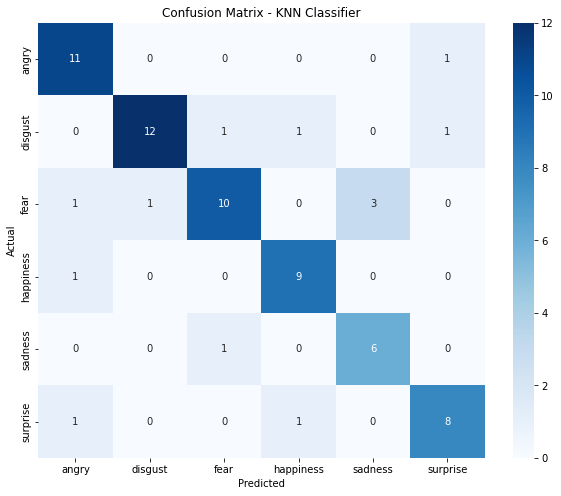

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


cm = confusion_matrix(y_test, y_pred_knn, labels=emotions)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=emotions, yticklabels=emotions)
plt.title('Confusion Matrix - KNN Classifier')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [22]:
import joblib

In [23]:
# Save the model to a file
model_filename = 'knn_model.pkl'
joblib.dump(knn, model_filename)

['knn_model.pkl']

In [24]:
from sklearn.metrics import classification_report,confusion_matrix

In [25]:
print(confusion_matrix(y_test,y_pred_knn))

[[11  0  0  0  0  1]
 [ 0 12  1  1  0  1]
 [ 1  1 10  0  3  0]
 [ 1  0  0  9  0  0]
 [ 0  0  1  0  6  0]
 [ 1  0  0  1  0  8]]


In [26]:
print(classification_report(y_test,y_pred_knn))

              precision    recall  f1-score   support

       angry       0.79      0.92      0.85        12
     disgust       0.92      0.80      0.86        15
        fear       0.83      0.67      0.74        15
   happiness       0.82      0.90      0.86        10
     sadness       0.67      0.86      0.75         7
    surprise       0.80      0.80      0.80        10

    accuracy                           0.81        69
   macro avg       0.80      0.82      0.81        69
weighted avg       0.82      0.81      0.81        69



In [27]:
report = pd.DataFrame(classification_report(y_test, y_pred_knn,output_dict=True)).transpose()

In [28]:
report

,precision,recall,f1-score,support
angry,0.785714,0.916667,0.846154,12.000000
disgust,0.923077,0.800000,0.857143,15.000000
fear,0.833333,0.666667,0.740741,15.000000
happiness,0.818182,0.900000,0.857143,10.000000
sadness,0.666667,0.857143,0.750000,7.000000
surprise,0.800000,0.800000,0.800000,10.000000
accuracy,0.811594,0.811594,0.811594,0.811594
macro avg,0.804496,0.823413,0.808530,69.000000
weighted avg,0.820626,0.811594,0.810776,69.000000


In [33]:
knn.classes_

array(['angry', 'disgust', 'fear', 'happiness', 'sadness', 'surprise'],
      dtype='<U9')

In [34]:
type(y_pred_knn)

numpy.ndarray